<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20230305.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datetime import datetime, date, time, timezone, timedelta
from functools import reduce
from collections import defaultdict
from scipy import stats
from scipy.stats import norm 

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'lead_conversion.csv',
 'app_wau.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv',
 'bz_data_analyis.csv',
 'sales.csv',
 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
 'sales_data_with_stores.csv',
 'sample-sales-data.csv',
 'online_retail_II.xlsx',
 '1_order_payments_dataset.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'mall_customers.csv',
 '1_customers_dataset.csv',
 'ab_experiment.csv',
 'ecommerce-data.csv',
 'mock_sales_data.csv',
 '1_orders_dataset.csv',
 'cookie_cats.csv',
 'online_retail.xlsx',
 'sales_vs_discount.csv',
 'groceries.csv',
 'scanner_data.csv',
 'test.csv',
 'match_result_test.csv',
 'sample_data']

In [4]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
cnt = pd.melt(df, id_vars = ['userid','version','sum_gamerounds'], var_name = 'retention', value_name = 'result')
cnt = cnt.groupby(['version','retention','result'])['userid'].count().reset_index(name = 'cnt')
cnt = cnt[cnt['result'] == True]
cnt

,version,retention,result,cnt
1,gate_30,retention_1,True,20034
3,gate_30,retention_7,True,8502
5,gate_40,retention_1,True,20119
7,gate_40,retention_7,True,8279


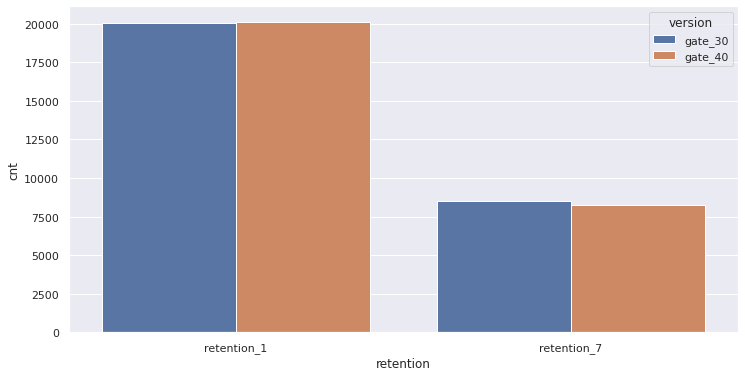

In [6]:
sns.set(rc = {'figure.figsize':[12,6]})
sns.barplot(data = cnt, x = 'retention', y = 'cnt', hue = 'version')
plt.show()

[]

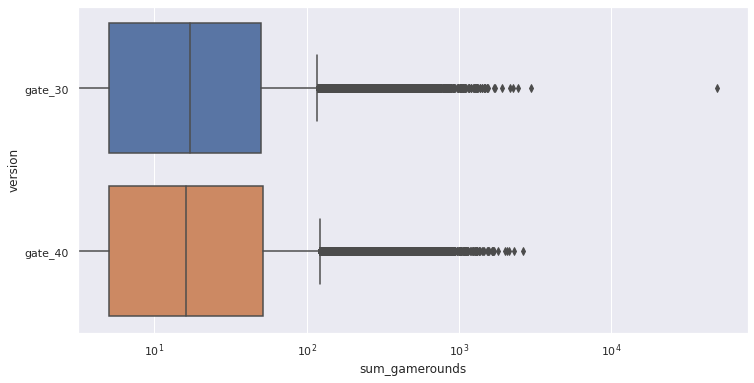

In [7]:
sns.set(rc = {'figure.figsize':[12,6]})
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.plot()

In [8]:
df = df[df['sum_gamerounds'] < 10000]

[]

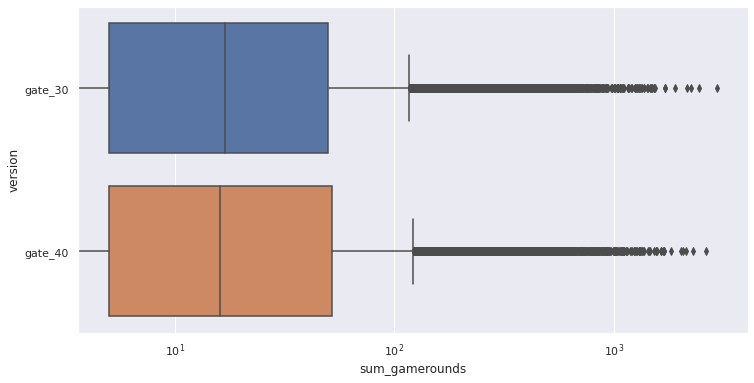

In [9]:
sns.set(rc = {'figure.figsize':[12,6]})
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.plot()

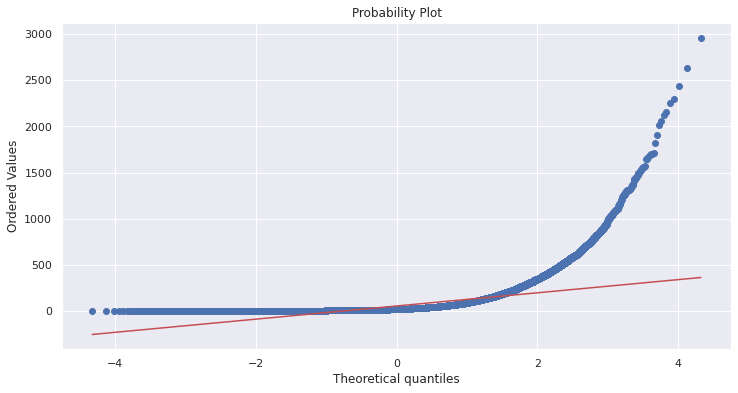

In [11]:
stats.probplot(df['sum_gamerounds'], dist = 'norm', plot = plt)
plt.show()

In [12]:
stat, p = stats.chisquare(df['sum_gamerounds'])
print(f'{round(stat,3)}\t{round(p,3)}')

18528909.99	0.0


In [13]:
res = stats.anderson(df['sum_gamerounds'])
res2 = zip(res.critical_values, res.significance_level)

In [14]:
[f'Probably Gaussian : critical value is {crit}, significance level is {sig}'
 if crit > sig
 else f'Probably not Gaussian : critical value is {crit}, significance level is {sig}'
 for crit, sig in res2
]

['Probably not Gaussian : critical value is 0.576, significance level is 15.0',
 'Probably not Gaussian : critical value is 0.656, significance level is 10.0',
 'Probably not Gaussian : critical value is 0.787, significance level is 5.0',
 'Probably not Gaussian : critical value is 0.918, significance level is 2.5',
 'Probably Gaussian : critical value is 1.092, significance level is 1.0']

In [15]:
n = 1000
boots = pd.DataFrame(
    [df.sample(frac = .1, replace = True).groupby(['version'])['sum_gamerounds'].mean() for i in range(n)]
)
boots.head()

version,gate_30,gate_40
sum_gamerounds,50.365133,51.743293
sum_gamerounds,51.139378,49.993675
sum_gamerounds,49.237626,49.111989
sum_gamerounds,50.965947,50.386876
sum_gamerounds,48.959255,49.367086


<AxesSubplot:ylabel='Density'>

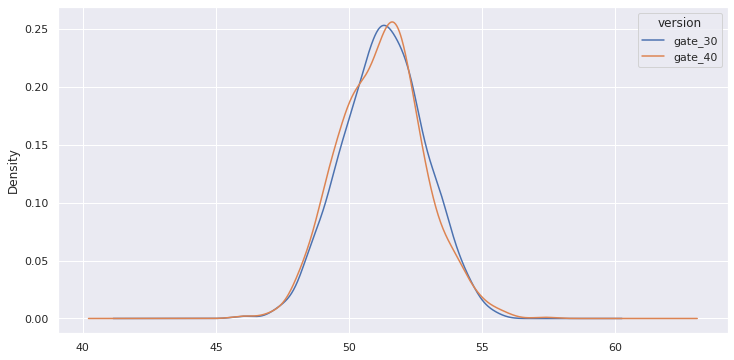

In [16]:
boots.plot.kde()

In [17]:
diff = boots['gate_30'] - boots['gate_40']
len(diff[diff > 0])/n

0.525

In [18]:
z_mean = np.mean(boots['gate_30']) - np.mean(boots['gate_40'])
z_sigma = np.sqrt(
    np.var(boots['gate_30'])/n + np.var(boots['gate_40'])/n
)
alpha = .05
ci_diff = [z_mean - norm.ppf(1-alpha/2)*z_sigma, z_mean + norm.ppf(1-alpha/2)*z_sigma]

In [20]:
print(f'Z Mean : {round(z_mean,3)}\nZ Sigma : {round(z_sigma, 3)}\nCI DIff : {round(ci_diff[0],2)}, {round(ci_diff[1],2)}')

Z Mean : 0.09
Z Sigma : 0.07
CI DIff : -0.05, 0.23


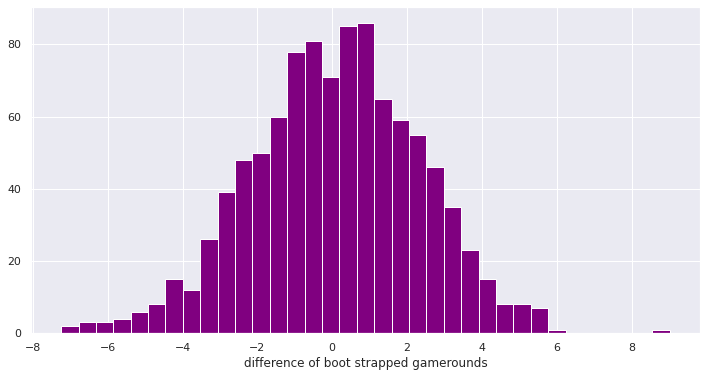

In [21]:
plt.hist(diff, bins = 35, color = 'purple')
plt.xlabel('difference of boot strapped gamerounds')
plt.show()

In [24]:
ret_1 = pd.crosstab(df['version'], df['retention_1'])
ret_7 = pd.crosstab(df['version'], df['retention_7'])

In [26]:
chi2, p, dof, ex = stats.chi2_contingency(ret_1)
print(f'CHI2 : {round(chi2,5)}\nP : {round(p,5)}\nDoF : {round(dof,5)}\nEX : {ex}')

CHI2 : 3.16984
P : 0.07501
DoF : 1
EX : [[24798.35970417 19900.64029583]
 [25236.64029583 20252.35970417]]


In [35]:
def get_chi2(data) :
  
  chi2, p, dof, ex = stats.chi2_contingency(data)
  alpha = .05
  
  res1 = f'Not enough evidence to reject H0' if p > alpha else f'two groups are differenct'
  res2 = f'P {round(p,5)} > Alpha {round(alpha,5)}' if p > alpha else f'P {round(p,5)} < Alpha {round(alpha,5)}' 

  print(res1)
  print(res2)
  print(f'CHI2 : {round(chi2,5)}\nP : {round(p,5)}\nDoF : {round(dof,5)}\nEX : {ex}')

In [36]:
get_chi2(ret_1)

Not enough evidence to reject H0
P 0.07501 > Alpha 0.05
CHI2 : 3.16984
P : 0.07501
DoF : 1
EX : [[24798.35970417 19900.64029583]
 [25236.64029583 20252.35970417]]


In [37]:
get_chi2(ret_7)

two groups are differenct
P 0.00164 < Alpha 0.05
CHI2 : 9.91528
P : 0.00164
DoF : 1
EX : [[36382.49203885  8316.50796115]
 [37025.50796115  8463.49203885]]


# Iterators

In [38]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [39]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}